#### 高效的嵌入法embedded
但是更有效的方法，毫无疑问会是我们的embedded嵌入法。我们已经说明了，由于L1正则化会使得部分特征对应的参数为0，因此L1正则化可以用来做特征选择，结合嵌入法的模块SelectFromModel，我们可以很容易就筛选出让模型十分高效的特征。注意，此时我们的目的是，尽量保留原数据上的信息，让模型在降维后的数据上的拟合效果保持优秀，因此我们不考虑训练集测试集的问题，把所有的数据都放入模型进行降维。

In [1]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.datasets import load_breast_cancer 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score 
from sklearn.feature_selection import SelectFromModel

In [2]:
data=load_breast_cancer()
data.data.shape

(569, 30)

In [3]:
LR_=LR(solver="liblinear",C=0.9,random_state=420)
cross_val_score(LR_,data.data,data.target,cv=10).mean()

0.9508145363408522

In [4]:
X_embedded=SelectFromModel(LR_,norm_order=1).fit_transform(data.data,data.target)

In [5]:
X_embedded.shape

(569, 9)

看看结果，特征数量被减小到个位数，并且模型的效果却没有下降太多，如果我们要求不高，在这里其实就可以停下了。但是，能否让模型的拟合效果更好呢？在这里，我们有两种调整方式：

- 1）调节SelectFromModel这个类中的参数threshold，这是嵌入法的阈值，表示删除所有参数的绝对值低于这个阈值的特征。现在threshold默认为None，所以SelectFromModel只根据L1正则化的结果来选择了特征，即选择了所有L1正则化后参数不为0的特征。我们此时，只要调整threshold的值（画出threshold的学习曲线），就可以观察不同的threshold下模型的效果如何变化。一旦调整threshold，就不是在使用L1正则化选择特征，而是使用模型的属性.coef_中生成的各个特征的系数来选择。coef_虽然返回的是特征的系数，但是系数的大小和决策树中的
feature_importances_以及降维算法中的可解释性方差explained_vairance_概念相似，其实都是衡量特征的重要程度和贡献度的，因此SelectFromModel中的参数threshold可以设置为coef_的阈值，即可以剔除系数小于
threshold中输入的数字的所有特征。

(0.0, 30)
(0.10674043184877162, 17)
(0.21348086369754324, 12)
(0.32022129554631484, 11)
(0.4269617273950865, 8)
(0.5337021592438581, 8)
(0.6404425910926297, 6)
(0.7471830229414014, 5)
(0.853923454790173, 5)
(0.9606638866389445, 5)
(1.0674043184877162, 5)
(1.174144750336488, 4)
(1.2808851821852594, 2)
(1.387625614034031, 2)
(1.4943660458828028, 2)
(1.6011064777315742, 1)
(1.707846909580346, 1)
(1.8145873414291176, 1)
(1.921327773277889, 1)
(2.0280682051266608, 1)


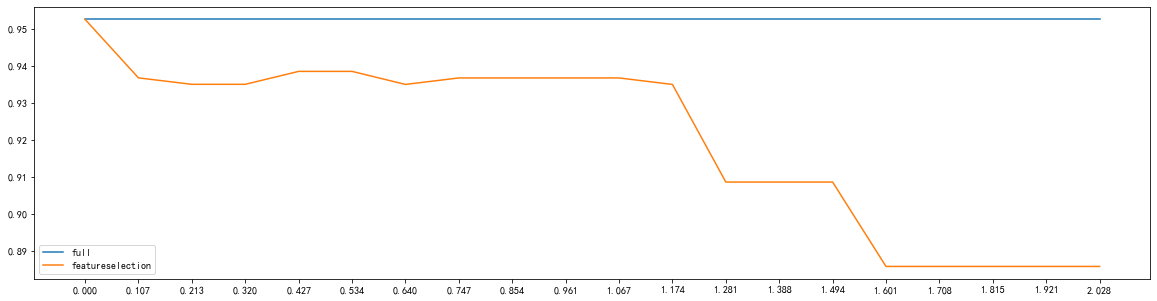

In [8]:
fullx=[]
fsx=[]
threshold=np.linspace(0,abs((LR_.fit(data.data,data.target).coef_)).max(),20)
k=0 
for i in threshold:
    X_embedded=SelectFromModel(LR_,threshold=i).fit_transform(data.data,data.target)
    fullx.append(cross_val_score(LR_,data.data,data.target,cv=5).mean())
    fsx.append(cross_val_score(LR_,X_embedded,data.target,cv=5).mean())
    print((threshold[k],X_embedded.shape[1]))
    k+=1 

plt.figure(figsize=(20,5))
plt.plot(threshold,fullx,label="full")
plt.plot(threshold,fsx,label="featureselection")
plt.xticks(threshold)
plt.legend()
plt.show()

然而，这种方法其实是比较无效的，大家可以用学习曲线来跑一跑：当threshold越来越大，被删除的特征越来越多，模型的效果也越来越差，模型效果最好的情况下需要保证有17个以上的特征。实际上我画了细化的学习曲线，如果要保证模型的效果比降维前更好，我们需要保留25个特征，这对于现实情况来说，是一种无效的降维：需要
30个指标来判断病情，和需要25个指标来判断病情，对医生来说区别不大。

- 2）第二种调整方法，是调逻辑回归的类LR_，通过画C的学习曲线来实现：

0.9543546365914788 4.01


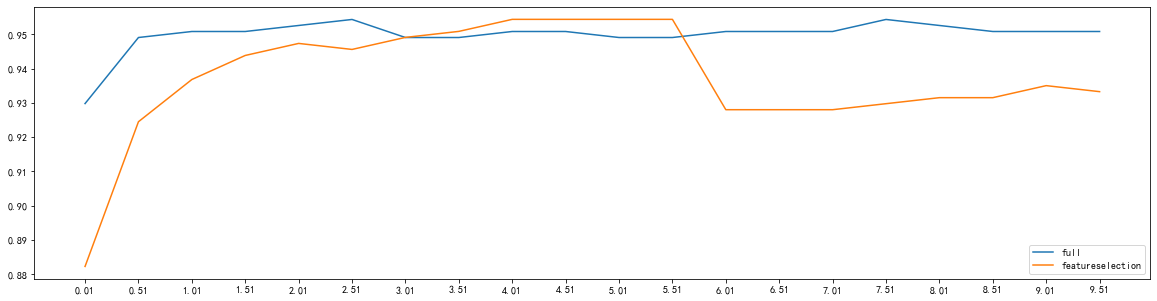

In [11]:
fullx=[]
fsx=[]
C=np.arange(0.01,10.01,0.5)
for i in C:
    LR_=LR(solver="liblinear",C=i,random_state=420)
    fullx.append(cross_val_score(LR_,data.data,data.target,cv=10).mean())
    X_embedded=SelectFromModel(LR_,norm_order=1).fit_transform(data.data,data.target)
    fsx.append(cross_val_score(LR_,X_embedded,data.target,cv=10).mean())
print(max(fsx),C[fsx.index(max(fsx))])
plt.figure(figsize=(20,5))
plt.plot(C,fullx,label="full")
plt.plot(C,fsx,label="featureselection")
plt.xticks(C)
plt.legend()
plt.show()

### 锁定范围继续画学习曲线

0.9543546365914788 3.599999999999998


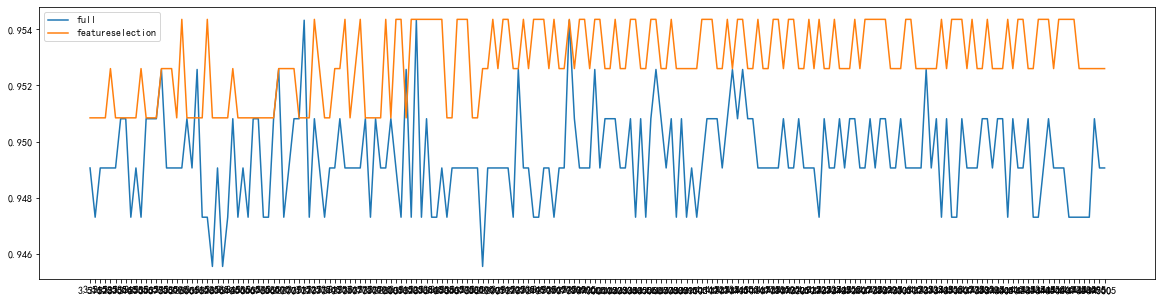

In [12]:
fullx=[]
fsx=[]
C=np.arange(3.51,4.51,0.005)
for i in C:
    LR_=LR(solver="liblinear",C=i,random_state=420)
    fullx.append(cross_val_score(LR_,data.data,data.target,cv=10).mean())
    X_embedded=SelectFromModel(LR_,norm_order=1).fit_transform(data.data,data.target)
    fsx.append(cross_val_score(LR_,X_embedded,data.target,cv=10).mean())
print(max(fsx),C[fsx.index(max(fsx))])
plt.figure(figsize=(20,5))
plt.plot(C,fullx,label="full")
plt.plot(C,fsx,label="featureselection")
plt.xticks(C)
plt.legend()
plt.show()

### 验证模型效果

In [14]:
#验证模型效果：降维之前
LR_=LR(solver="liblinear",C=3.599999999999998,random_state=420)
cross_val_score(LR_,data.data,data.target,cv=10).mean()

0.9490601503759398

In [15]:
#验证模型效果：降维之后
LR_=LR(solver="liblinear",C=6.069999999999999,random_state=420)
X_embedded=SelectFromModel(LR_,norm_order=1).fit_transform(data.data,data.target)
cross_val_score(LR_,X_embedded,data.target,cv=10).mean()

0.9280075187969924

In [16]:
X_embedded.shape

(569, 9)

这样我们就实现了在特征选择的前提下，保持模型拟合的高效，现在，如果有一位医生可以来为我们指点迷津，看看剩下的这些特征中，有哪些是对针对病情来说特别重要的，也许我们还可以继续降维。当然，除了嵌入法，系数累加法或者包装法也是可以使用的。